# Single Layerd Bigram Model

In [2]:
import torch
import matplotlib.pyplot as plot
import torch.nn.functional as F

## Examining The Data

In [3]:
words = open('../data/names.txt', 'r').read().splitlines()

In [4]:
print(f'num of words: {len(words)}')
print(f'first 10 words: {words[:10]}')

num of words: 32033
first 10 words: ['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia', 'harper', 'evelyn']


In [5]:
# A bigram language model we're only working with two characters at a time. We're looking at one character and trying to predict what comes next.
# let's look at first few bigrams in our dataset
bigram_freq = {}
for w in words[:3]:
    chars = ['<S>'] + list(w) + ['<E>']
    for ch1, ch2 in zip(chars, chars[1:]):
        bigram = (ch1, ch2)
        bigram_freq[bigram] = bigram_freq.get(bigram, 0) + 1 # count the frequency of bigram and update it
        print(ch1, ch2)

<S> e
e m
m m
m a
a <E>
<S> o
o l
l i
i v
v i
i a
a <E>
<S> a
a v
v a
a <E>


In [6]:
bigram_freq

{('<S>', 'e'): 1,
 ('e', 'm'): 1,
 ('m', 'm'): 1,
 ('m', 'a'): 1,
 ('a', '<E>'): 3,
 ('<S>', 'o'): 1,
 ('o', 'l'): 1,
 ('l', 'i'): 1,
 ('i', 'v'): 1,
 ('v', 'i'): 1,
 ('i', 'a'): 1,
 ('<S>', 'a'): 1,
 ('a', 'v'): 1,
 ('v', 'a'): 1}

In [7]:
bigram_freq = {}
for w in words:
    chars = ['<S>'] + list(w) + ['<E>']
    for ch1, ch2 in zip(chars, chars[1:]):
        bigram = (ch1, ch2)
        bigram_freq[bigram] = bigram_freq.get(bigram, 0) + 1  # count the frequency of bigram and update it

In [8]:
len(bigram_freq)

627

In [9]:
list(bigram_freq.items())[:5]

[(('<S>', 'e'), 1531),
 (('e', 'm'), 769),
 (('m', 'm'), 168),
 (('m', 'a'), 2590),
 (('a', '<E>'), 6640)]

In [10]:
# bigrams sorted by likeliness
sorted_bigrams = sorted(bigram_freq.items(), key = lambda kv: -kv[1])
sorted_bigrams[:5]

[(('n', '<E>'), 6763),
 (('a', '<E>'), 6640),
 (('a', 'n'), 5438),
 (('<S>', 'a'), 4410),
 (('e', '<E>'), 3983)]

## Getting The Counts Of The Bigrams

In [11]:
# bigram freqs as tensor
bi_fq_tensor = torch.zeros((27, 27), dtype=torch.int32)

`27, 27` because we are creating a table of counts of all the bigrams and both characters can take 27 different variations.

In [12]:
# build vocabulary of tokens
chars = sorted(list(set(''.join(words))))
char_to_int_map = {ch:i+1 for i, ch in enumerate(chars)}
char_to_int_map['.'] = 0 # add . as separator token so total becomes 27
char_to_int_map

{'a': 1,
 'b': 2,
 'c': 3,
 'd': 4,
 'e': 5,
 'f': 6,
 'g': 7,
 'h': 8,
 'i': 9,
 'j': 10,
 'k': 11,
 'l': 12,
 'm': 13,
 'n': 14,
 'o': 15,
 'p': 16,
 'q': 17,
 'r': 18,
 's': 19,
 't': 20,
 'u': 21,
 'v': 22,
 'w': 23,
 'x': 24,
 'y': 25,
 'z': 26,
 '.': 0}

In [13]:
int_to_ch_map = {i:ch for ch, i in char_to_int_map.items()}
int_to_ch_map

{1: 'a',
 2: 'b',
 3: 'c',
 4: 'd',
 5: 'e',
 6: 'f',
 7: 'g',
 8: 'h',
 9: 'i',
 10: 'j',
 11: 'k',
 12: 'l',
 13: 'm',
 14: 'n',
 15: 'o',
 16: 'p',
 17: 'q',
 18: 'r',
 19: 's',
 20: 't',
 21: 'u',
 22: 'v',
 23: 'w',
 24: 'x',
 25: 'y',
 26: 'z',
 0: '.'}

Count all the bigrams in the dataset by:

1. Taking a word and adding `.` at the start and at the end to make the word start and end with `.`, our separator token.
2. Take two characters at a time (bigram) from this word and get the indices of the characters. These indices form the index of the bigram frequency table which we need to increment.

In [14]:
for w in words:
    chars = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chars, chars[1:]):
        ix1 = char_to_int_map[ch1]
        ix2 = char_to_int_map[ch2]
        bi_fq_tensor[ix1, ix2] += 1

(-0.5, 26.5, 26.5, -0.5)

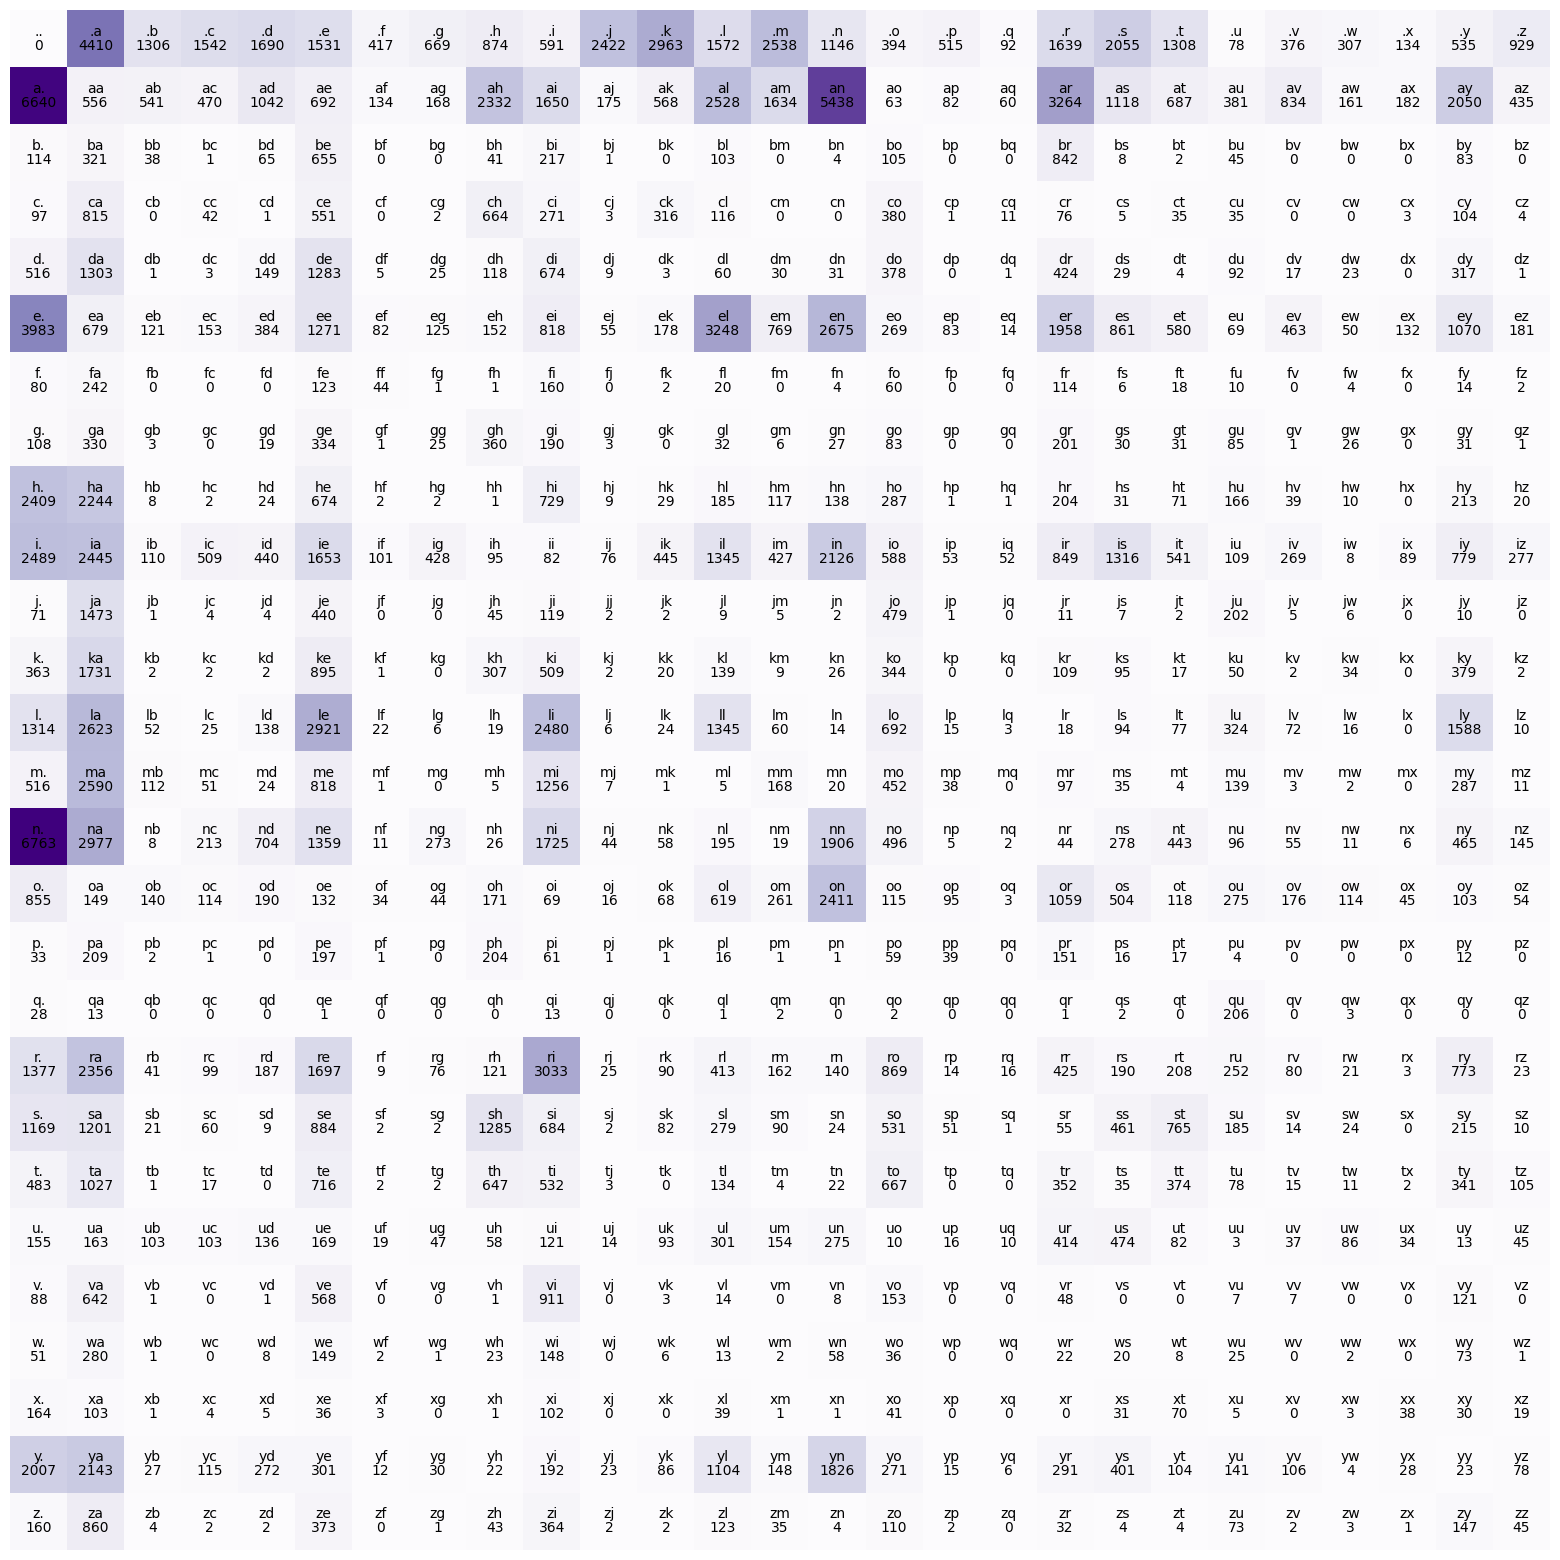

In [17]:
plot.figure(figsize=(20,20))
plot.imshow(bi_fq_tensor, cmap='Purples')
for i in range(27):
    for j in range(27):
        chstr = int_to_ch_map[i] + int_to_ch_map[j]
        plot.text(j, i, chstr, ha='center', va='bottom', color='black')
        plot.text(j, i, bi_fq_tensor[i, j].item(), ha='center', va='top', color='black')
plot.axis('off')

We have the counts of all the bigarms in our dataset which we can now use to calculate the probabity of their occurences.

In [15]:
# first row of tensor
bi_fq_tensor[0]

tensor([   0, 4410, 1306, 1542, 1690, 1531,  417,  669,  874,  591, 2422, 2963,
        1572, 2538, 1146,  394,  515,   92, 1639, 2055, 1308,   78,  376,  307,
         134,  535,  929], dtype=torch.int32)

In [16]:
# sum of all counts
bi_fq_tensor.sum()

tensor(228146)

Probability of a character to be the first character of the word comes from the first row of our counts tensor in which `ch1=.`.

In [21]:
# get probability of any char to be the first character of the word
probs = bi_fq_tensor[0].float()
probs = probs / probs.sum()
probs

tensor([0.0000, 0.1377, 0.0408, 0.0481, 0.0528, 0.0478, 0.0130, 0.0209, 0.0273,
        0.0184, 0.0756, 0.0925, 0.0491, 0.0792, 0.0358, 0.0123, 0.0161, 0.0029,
        0.0512, 0.0642, 0.0408, 0.0024, 0.0117, 0.0096, 0.0042, 0.0167, 0.0290])

### Sampling From A Probability Distribution

In [18]:
# an example of sampling from a distribution
ex_p = torch.rand(3)
ex_p = ex_p / ex_p.sum()
print(f'example probabilities: {ex_p}\n')
# torch.multinomial picks out samples from a probability distribution 
torch.multinomial(ex_p, num_samples=20, replacement=True) # replacement = true means that an element can be sampled again after being sampled

# notice that the elements in the sample are according to their probabilities in the distribution

example probabilities: tensor([0.3271, 0.4734, 0.1995])



tensor([0, 0, 2, 2, 1, 1, 2, 2, 0, 0, 1, 1, 0, 1, 2, 0, 1, 0, 1, 1])

### Sampling First Character From Our Distribution

In [24]:
# sampling from our distribution
idx = torch.multinomial(probs, num_samples=1, replacement=True)
print(f'idx: {idx}\n')
idx = idx.item()
print(f'idx: {idx}\n')
print(f'sample char: {int_to_ch_map[idx]}\n')

idx: tensor([14])

idx: 14

sample char: n



## Sampling Names Just By Using Our Probability Distribution

In [20]:
# get a name by sampling character depending on previous character
for i in range(10):
    samples = []
    idx = 0 # first pick a char from the first row
    while True:
        p = bi_fq_tensor[idx].float()
        p = p / p.sum()
        idx = torch.multinomial(p, num_samples=1, replacement=True).item() # replacement=True doesn't modify the counts after sampling so our counts stay intact
        samples.append(int_to_ch_map[idx]) # get ch from index
        if idx == 0:
            # break when you reach the end token
            break
    print(''.join(samples))

s.
krladube.
kae.
quch.
jahaccllemi.
x.
amo.
c.
leemanavanony.
yndazya.


- The above loop starts by sampling a character from the first row of the tensor to pick the first character in the sequence.
- Then the predicted character becomes the index for the next prediction to get the next character until we get `.` and break of out the loop.

The results aren't great because we are using a Bigram model which only looks at a single character to predict the next one.

The following code outputs predictions without taking probabilities into account.

In [25]:
for i in range(10):
    samples = []
    idx = 0
    while True:
        p = torch.ones(27) / 27.0
        idx = torch.multinomial(p, num_samples=1, replacement=True).item()
        samples.append(int_to_ch_map[idx])
        if idx == 0:
            # break when you reach the end token
            break
    print(''.join(samples))

u.
xye.
o.
pmvxpjxetsevmrnvulbymhxvlixnjesacrrtxv.
qcfgvdrqasuoxwqgj.
ajkrbtglcxxocozwcvnlzwfflccclelamqquibgejfcymexxbazhv.
zztzpceapztlvytbntq.
aicwoyfavltzbpzngtfgasgb.
jvxefde.
wmsvpfizkccwn.


## Optimizing Probability Calculation Using Matrices

Instead of calculating the sum and performing division in every iteration of the loop. We can use tensor operations to calcluate probabilies of every bigram in a very efficient manner by leverging broadcasting.

**Boardcasting is a key operation when working with Tensors so look into this more.**

In [27]:
Probs = bi_fq_tensor.float()

In [23]:
Probs.shape

torch.Size([27, 27])

In [24]:
Probs.sum()

tensor(228146.)

Perform a sum across all elements in a row.

In [25]:
Probs.sum(1, keepdim=True).shape

torch.Size([27, 1])

Row wise probabilities for all bigrams in the distribution can be calculated as follows:

In [28]:
Probs = Probs / Probs.sum(1, keepdim=True)

By updating our sampling method to use `Probs` we get:

In [27]:
for i in range(10):
    samples = []
    idx = 0
    while True:
        p = Probs[idx]
        idx = torch.multinomial(p, num_samples=1, replacement=True).item()
        samples.append(int_to_ch_map[idx])
        if idx == 0:
            # break when you reach the end token
            break
    print(''.join(samples))

kydyeyelaizlis.
kathnelay.
mmaharey.
phakon.
deleydamindin.
data.
ds.
don.
illashe.
jan.


## Loss Function

In order to train our model we need a loss a function against which we can optimize our network.

## Likelihood

Likelihood is used as a metric to get an idea of how well the model is performing. It's calculated as the product of all these probabilities. It gives the probability of the entire dataset assigned by the model. The closer that figure is to 1, the better the model is performing.

### Log Likelihood

Since these probabilities are small numbers less than 1, their product is a number even smaller. So for convenience we use take the log of these probabilities. The sum of these probabilities is called the log likelihood.

In [28]:
log_likelihood = 0.0

for w in words[:3]:
    chars = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chars, chars[1:]):
        ix1 = char_to_int_map[ch1]
        ix2 = char_to_int_map[ch2]
        prob = Probs[ix1, ix2]
        logprob = torch.log(prob)
        log_likelihood += logprob
        print(f'{ch1}{ch2}: {prob:.4f} {logprob:.4}')

print(f'log likelihood: {log_likelihood}')       

.e: 0.0478 -3.041
em: 0.0377 -3.279
mm: 0.0253 -3.677
ma: 0.3899 -0.9418
a.: 0.1960 -1.63
.o: 0.0123 -4.398
ol: 0.0780 -2.551
li: 0.1777 -1.728
iv: 0.0152 -4.187
vi: 0.3541 -1.038
ia: 0.1381 -1.98
a.: 0.1960 -1.63
.a: 0.1377 -1.983
av: 0.0246 -3.704
va: 0.2495 -1.388
a.: 0.1960 -1.63
log likelihood: -38.78563690185547


### Negative Log Likelihood

Our log likelihood came to be a negative number which makes sense because `log(1) = 0` and numbers below 1 have a negative log. We can't use this function as is as a loss function because for a loss function lower is better. That means better probabilities (closer to one) should result in a lower loss instead of the other way around. So we take the negative log likelihood as our loss function.

NLL is a good loss function because the lowest it can get is 0 (for prob = 1) and the higher it is, the worse are the predictions.

In [29]:
nll = - log_likelihood
print(f'negative log likelihood: {-log_likelihood}')

negative log likelihood: 38.78563690185547


One last thing to do in this loss function is to normalize it by taking it as an average instead of a sum.

In [29]:
log_likelihood = 0.0
n = 0

for w in words:
    chars = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chars, chars[1:]):
        ix1 = char_to_int_map[ch1]
        ix2 = char_to_int_map[ch2]
        prob = Probs[ix1, ix2]
        logprob = torch.log(prob)
        log_likelihood += logprob
        n += 1

print(f'loss: {-log_likelihood / n}')  # average negative log likelihood

loss: 2.454094171524048


The above function gets the log probs of all the bigrams in our dataset. Sums them up to get the log likelihood of the overall dataset and then divides it by the number of all bigrams. The negative of that figure gives the average negative log likelihood for the entire dataset assigned by the model (which isn't one right now but as we train a network these probabilities will be modified by the network) which is the overall loss.

### Model Smoothing

If we have a bigram which has zero probability then it's loss will be infinity which is undesirable. To fix these we use model smoothing. We do this by adding some fake counts.

In [31]:
-torch.log(torch.tensor(0))

tensor(inf)

In [32]:
# add a count of 1 for every sample to prevent zeros
# this number can be any constant
# the more you add the more uniform model we'll have
# using smaller numbers will a peaked model
Probs = (bi_fq_tensor + 1).float() 
Probs = Probs / Probs.sum(1, keepdim=True)

## Building A Neural Network

### Building A Training Set

We'll create a dataset to train our model on. It comprises of `inputs` i.e. the character for the model to base the prediction on and the `targets` i.e. the correct character that should be predicted. These datasets are made up of indices of the characters according to our vocabulary so that later we can create their embeddings easily.

### Checking For Just The First Word

In [32]:
inputs, targets = [], []

for w in words[:1]:
    chars = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chars, chars[1:]):
        ix1 = char_to_int_map[ch1]
        ix2 = char_to_int_map[ch2]
        print(ch1, ch2)
        inputs.append(ix1)
        targets.append(ix2)

# create tensors from the lists
inputs = torch.tensor(inputs)        
targets = torch.tensor(targets)

. e
e m
m m
m a
a .


In [33]:
print(f'inputs: {inputs}\n') # . e m m a
print(f'targets: {targets}\n') # e m m a .

inputs: tensor([ 0,  5, 13, 13,  1])

targets: tensor([ 5, 13, 13,  1,  0])



### Building The Overall Dataset

In [37]:
inputs, targets = [], []

for w in words:
    chars = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chars, chars[1:]):
        ix1 = char_to_int_map[ch1]
        ix2 = char_to_int_map[ch2]
        inputs.append(ix1)
        targets.append(ix2)

# create tensors from the lists
inputs = torch.tensor(inputs)        
targets = torch.tensor(targets)

In [38]:
print(inputs.shape, targets.shape)

torch.Size([228146]) torch.Size([228146])


### Neural Network

Neural Networks are made up of neurons which have weights assciated with them. These weights act multiplicatively (`y = w @ x + b`, where `w` are the weights of all the neurons in the network, `x` are the input embeddings and `b` are the biases) on the inputs to generate activations. 

Our network will take a single character as input, inact its weights and output a probability distribution over the next character in the sequence. We'll be able to evaluate the weights of the model through our loss function. We'll use gradient based optimization to tune the weights to give better output.

### One Hot Encoding

A one-hot vector is a 1 × N matrix (vector) used to distinguish each word in a vocabulary from every other word in the vocabulary. The vector consists of 0s in all cells with the exception of a single 1 in a cell used uniquely to identify the word. 

We'll use it to encode our integers. For example while encoding the integer 13, all values in the vector will be 0 except the 13th dimension which will be 1. This vector will be the input to our NN. 

In [41]:
inputs_enc = F.one_hot(inputs, num_classes=27) # num_classes is how large the vector should be. We have 27 ints in our vocab hence 27
inputs_enc[:5]

tensor([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0]])

The above output shows the vector embeddings for the word "emma". Notice that the sequence starts at index 0 which is our separator token.

In [42]:
inputs_enc.shape

torch.Size([228146, 27])

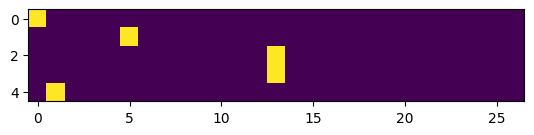

In [44]:
plot.imshow(inputs_enc[:5]);

We've encoded the small example batch into vectors. Notice that the appropriate bit is turned on as a 1 and everything else is 0.

**Note:** when we plug numbers into a neural network, we want them as floating point numbers instead of integers so make sure to check the `dtype`.

In [45]:
inputs_enc.dtype 

torch.int64

In [47]:
# we'll have to cast our encoding to float
inputs_enc = F.one_hot(inputs, num_classes=27).float()

torch.Size([228146, 27])

In [42]:
inputs_enc.dtype

torch.float32

### Constructing A Neuron

Each neuron in a NN performs the operation `y = wx + b`, where `a` are the activations for the next layer (in case of multi layer networks), `w` are the weights of that layer, `x` is the input vector and `b` is the bias.

In [48]:
# initialize the weights of a neuron
w = torch.randn((27, 1)) # passing the size as 27, 1
w

tensor([[ 1.3579],
        [-0.3812],
        [ 0.9304],
        [-0.8919],
        [ 0.2443],
        [ 0.8757],
        [-1.8749],
        [-0.2094],
        [-0.3668],
        [ 0.0038],
        [-1.2529],
        [ 0.9883],
        [-1.3035],
        [-1.1940],
        [-0.1467],
        [-0.3996],
        [-1.6408],
        [-0.4741],
        [-0.0869],
        [-0.4023],
        [ 0.7536],
        [-1.9638],
        [ 0.2050],
        [-0.2508],
        [ 1.6619],
        [-0.0359],
        [-0.4662]])

Our weight matrix is of the dimension `27, 1` because when we perform the matrix multiplication operation with an input matrix of dim `27, 27` `x @ w` will give an output of dim `27, 1` which means a probability distribution of 27 tokens which is what we want.

In [50]:
# performing matmul of inputs with w
inputs_enc[:5] @ w # 5, 27 * 27, 1 -> 5, 1 

tensor([[ 1.3579],
        [ 0.8757],
        [-1.1940],
        [-1.1940],
        [-0.3812]])

`w` represents the 5 activations of this neuron on these 5 inputs. We evaluated (performed the operation `w*x + b` with `b=0`) all of them in parallel using pytorch.

Next up, instead of having just 1 neuron we'll have 27 neurons.

In [51]:
w = torch.randn((27, 27))
inputs_enc[:5] @ w # evaluate all 27 neurons on all 5 inputs in parallel

tensor([[-0.5445, -1.1473, -0.9193, -1.4766,  1.2999, -1.4042, -1.5977,  0.5747,
         -0.7924,  0.7867, -0.5890,  0.2756, -0.5176, -0.4150, -0.3480,  0.6809,
          0.8472,  1.0934,  2.1834,  0.5407, -0.4583, -0.1579, -0.1795,  0.5762,
          1.4798, -0.2249,  1.5533],
        [-0.4896, -0.2578,  1.6471,  0.0028, -0.9068, -0.3828,  0.7071, -1.2097,
          0.2104,  0.5561, -1.0568,  0.9814, -0.1564,  0.7941, -0.2992,  0.7302,
          0.4464, -0.8242,  2.6448,  0.1225,  0.1703,  0.3246,  0.3547,  0.3910,
          2.4233,  0.2536, -1.6892],
        [ 0.3157, -0.0214,  0.5272,  0.6394, -0.6726, -2.1549,  0.4662, -0.1024,
          0.6957, -0.8833, -1.4758,  0.8167, -0.0886,  0.2796, -0.0271,  0.2565,
         -0.0478, -1.9579, -0.2563, -0.3186,  0.2734, -0.0889, -0.0195,  2.4804,
         -0.0940,  1.3672,  1.4425],
        [ 0.3157, -0.0214,  0.5272,  0.6394, -0.6726, -2.1549,  0.4662, -0.1024,
          0.6957, -0.8833, -1.4758,  0.8167, -0.0886,  0.2796, -0.0271,  0.2565

Every element in the results tells us the firing rate of those neurons on every one of those 5 examples.

In [52]:
(inputs_enc @ w)[3, 13] # firing rate of the 13th neuron looking at the third input

tensor(0.2796)

## Logits

We have fed our 27 dimensional input into the first layer of a neural network that has 27 neurons. This layer of neurons is a linear layer and they don't have a bias. Our simple neural net will just be a single layered NN.

We are expecting the outputs after passing through the layer to be the probability distribution for the next character. Right now the output is just some numbers which are both positive and negative. We want them to represent probabilities. In a probability distribution, all numbers are positive and they sum to 1. That's not the output for this NN.

Instead the NN gives 27 numbers which represent the log counts aka `logits`. To get the counts from the output we'll exponentiate the log counts. 

In [53]:
logits = inputs_enc @ w # log counts
logits[:5]

tensor([[-0.5445, -1.1473, -0.9193, -1.4766,  1.2999, -1.4042, -1.5977,  0.5747,
         -0.7924,  0.7867, -0.5890,  0.2756, -0.5176, -0.4150, -0.3480,  0.6809,
          0.8472,  1.0934,  2.1834,  0.5407, -0.4583, -0.1579, -0.1795,  0.5762,
          1.4798, -0.2249,  1.5533],
        [-0.4896, -0.2578,  1.6471,  0.0028, -0.9068, -0.3828,  0.7071, -1.2097,
          0.2104,  0.5561, -1.0568,  0.9814, -0.1564,  0.7941, -0.2992,  0.7302,
          0.4464, -0.8242,  2.6448,  0.1225,  0.1703,  0.3246,  0.3547,  0.3910,
          2.4233,  0.2536, -1.6892],
        [ 0.3157, -0.0214,  0.5272,  0.6394, -0.6726, -2.1549,  0.4662, -0.1024,
          0.6957, -0.8833, -1.4758,  0.8167, -0.0886,  0.2796, -0.0271,  0.2565,
         -0.0478, -1.9579, -0.2563, -0.3186,  0.2734, -0.0889, -0.0195,  2.4804,
         -0.0940,  1.3672,  1.4425],
        [ 0.3157, -0.0214,  0.5272,  0.6394, -0.6726, -2.1549,  0.4662, -0.1024,
          0.6957, -0.8833, -1.4758,  0.8167, -0.0886,  0.2796, -0.0271,  0.2565

In [54]:
# element-wise exponentiating log counts
counts = logits.exp()
counts[:5]

tensor([[ 0.5801,  0.3175,  0.3988,  0.2284,  3.6689,  0.2456,  0.2024,  1.7767,
          0.4528,  2.1961,  0.5549,  1.3174,  0.5959,  0.6603,  0.7061,  1.9756,
          2.3331,  2.9843,  8.8763,  1.7172,  0.6324,  0.8540,  0.8357,  1.7792,
          4.3921,  0.7986,  4.7270],
        [ 0.6129,  0.7728,  5.1918,  1.0028,  0.4038,  0.6820,  2.0281,  0.2983,
          1.2342,  1.7439,  0.3476,  2.6682,  0.8552,  2.2125,  0.7414,  2.0756,
          1.5626,  0.4386, 14.0800,  1.1303,  1.1856,  1.3835,  1.4258,  1.4784,
         11.2826,  1.2887,  0.1847],
        [ 1.3712,  0.9789,  1.6941,  1.8953,  0.5104,  0.1159,  1.5939,  0.9027,
          2.0052,  0.4134,  0.2286,  2.2630,  0.9153,  1.3226,  0.9733,  1.2923,
          0.9534,  0.1411,  0.7739,  0.7272,  1.3144,  0.9150,  0.9807, 11.9463,
          0.9103,  3.9245,  4.2313],
        [ 1.3712,  0.9789,  1.6941,  1.8953,  0.5104,  0.1159,  1.5939,  0.9027,
          2.0052,  0.4134,  0.2286,  2.2630,  0.9153,  1.3226,  0.9733,  1.2923

Now to get the probabilities we just have to normalize the counts.

In [56]:
probs = counts / counts.sum(1, keepdim=True)
probs[:5]

tensor([[0.0127, 0.0069, 0.0087, 0.0050, 0.0801, 0.0054, 0.0044, 0.0388, 0.0099,
         0.0479, 0.0121, 0.0288, 0.0130, 0.0144, 0.0154, 0.0431, 0.0509, 0.0651,
         0.1938, 0.0375, 0.0138, 0.0186, 0.0182, 0.0388, 0.0959, 0.0174, 0.1032],
        [0.0105, 0.0133, 0.0890, 0.0172, 0.0069, 0.0117, 0.0348, 0.0051, 0.0212,
         0.0299, 0.0060, 0.0458, 0.0147, 0.0379, 0.0127, 0.0356, 0.0268, 0.0075,
         0.2415, 0.0194, 0.0203, 0.0237, 0.0245, 0.0254, 0.1935, 0.0221, 0.0032],
        [0.0303, 0.0216, 0.0374, 0.0418, 0.0113, 0.0026, 0.0352, 0.0199, 0.0443,
         0.0091, 0.0050, 0.0500, 0.0202, 0.0292, 0.0215, 0.0285, 0.0210, 0.0031,
         0.0171, 0.0161, 0.0290, 0.0202, 0.0217, 0.2637, 0.0201, 0.0866, 0.0934],
        [0.0303, 0.0216, 0.0374, 0.0418, 0.0113, 0.0026, 0.0352, 0.0199, 0.0443,
         0.0091, 0.0050, 0.0500, 0.0202, 0.0292, 0.0215, 0.0285, 0.0210, 0.0031,
         0.0171, 0.0161, 0.0290, 0.0202, 0.0217, 0.2637, 0.0201, 0.0866, 0.0934],
        [0.0085, 0.0467,

In [57]:
probs.shape

torch.Size([228146, 27])

In [58]:
# since they are probs every row will sum to 1
probs[0].sum()

tensor(1.)

For example, we now have a row as an output from a NN and because of the transformations we have made sure that the output is probabilities.

**Note:** all our operations (our forward pass) are differentiable operations that we can backpropagate through.

In [59]:
# take a look at the 0th example
probs[0]

tensor([0.0127, 0.0069, 0.0087, 0.0050, 0.0801, 0.0054, 0.0044, 0.0388, 0.0099,
        0.0479, 0.0121, 0.0288, 0.0130, 0.0144, 0.0154, 0.0431, 0.0509, 0.0651,
        0.1938, 0.0375, 0.0138, 0.0186, 0.0182, 0.0388, 0.0959, 0.0174, 0.1032])

So the first row of `probs` gives the probability distribution of the next character when `.` is the input and so on for the other inputs.

As we tune the weights we'll get different probabilities for the next character. So the next step is to optimize and find a good `w` such that the output probabilities are good i.e the loss descreases.


### Process Till Now

1. We mapped our characters into integers.
2. One Hat encoded the input integers to get input vectors.
3. Passed these vector inputs to a single layer Neural Net. 
4. Transformed the logits from the NN to probability distribution for the next character.

## Softmax

In [77]:
counts = logits.exp()
probs = counts / counts.sum(1, keepdims=True)

The above two lines are called taking a softmax. It's a frequently used layer in a NN which takes the logits, exponentiates them and then normalizes them. It's a way of taking the outputs of a NN layer and converting them to a probability distribution. It's a normalization function that makes a NN output probs.

## Vectorized Loss

Our forward pass is:

In [85]:
w = torch.randn((27, 27), requires_grad=True) # so we can calc its grad in the bwd pass

In [86]:
# forward pass

inputs_enc = F.one_hot(inputs, num_classes=27).float()
logits = inputs_enc @ w
counts = logits.exp()
probs = counts / counts.sum(1, keepdims=True)

To calculate the loss we want to get the probabilities at the correct indices for the corresponding inputs. For example, for ".emma" the probabilites look like this:

In [87]:
probs[0, 5], probs[1, 13], probs[2, 13], probs[3, 1], probs[4, 0]

(tensor(0.0437, grad_fn=<SelectBackward0>),
 tensor(0.0150, grad_fn=<SelectBackward0>),
 tensor(0.0468, grad_fn=<SelectBackward0>),
 tensor(0.0231, grad_fn=<SelectBackward0>),
 tensor(0.0742, grad_fn=<SelectBackward0>))

In [88]:
# a more efficient way to do the same thing using pytorch is
# get a vector of 0 1 2 3 4
torch.arange(5)

tensor([0, 1, 2, 3, 4])

In [89]:
probs[torch.arange(5), targets] 

tensor([0.0437, 0.0150, 0.0468, 0.0231, 0.0742], grad_fn=<IndexBackward0>)

This gives us the probs assigned by the NN to the correct next character. Now we take their negative log likelihood by taking their log, averaging it and adding a negative sign to it. This gives us the loss of the network.

In [94]:
loss = - probs[torch.arange(5), targets].log().mean()
loss.item()

3.352759838104248

### Backward Pass

We have our forward pass and our loss so now we're ready to perform a backward pass.

In [91]:
w.grad = None # first make sure that all grads are reset to 0
loss.backward()

In [92]:
w.shape

torch.Size([27, 27])

In [93]:
w.grad[:5]

tensor([[ 0.0087,  0.0029,  0.0094,  0.0106,  0.0038, -0.1913,  0.0029,  0.0041,
          0.0190,  0.0024,  0.0018,  0.0019,  0.0123,  0.0165,  0.0065,  0.0012,
          0.0027,  0.0293,  0.0032,  0.0010,  0.0182,  0.0026,  0.0128,  0.0104,
          0.0003,  0.0011,  0.0056],
        [-0.1852,  0.0022,  0.0067,  0.0050,  0.0035,  0.0008,  0.0083,  0.0069,
          0.0061,  0.0011,  0.0068,  0.0120,  0.0021,  0.0089,  0.0142,  0.0043,
          0.0036,  0.0035,  0.0035,  0.0036,  0.0047,  0.0054,  0.0029,  0.0075,
          0.0012,  0.0567,  0.0038],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000

Each element in `w.grad` tells us the influence of that weight on the loss function. We can use this gradient information to update the weights in the NN.

In [95]:
# updating the weights
w.data += -0.1 * w.grad

Here 0.1 is the learning rate i.e. the rate at which we want to update the weights of the network.

In [104]:
# after updating the weights we expect the loss to decrease 

## fwd pass
inputs_enc = F.one_hot(inputs, num_classes=27).float()
logits = inputs_enc @ w
counts = logits.exp()
probs = counts / counts.sum(1, keepdims=True)

# loss
loss = - probs[torch.arange(5), targets].log().mean()
loss.item() 

3.3011810779571533

## Regularization Loss

Earlier we added fake counts to the counts table `bi_fq_tensor` to smoothen the counts and make the  probs distribution more uniform. We can do the same for the gradient based approach. Trying to incentivise `w` to be near zero is equivalent to label smoothening. To do so ee add a small component to the loss function called the regularization loss.

In [99]:
w = torch.randn((27, 27), requires_grad=True)

In [101]:
(w**2).mean()

tensor(0.9331, grad_fn=<MeanBackward0>)

When we add this term to the loss function, we achieve zero loss if `w` is exactly 0 but we accumulate loss if `w` is non zero.

In [102]:
loss = - probs[torch.arange(5), targets].log().mean() + 0.01*(w**2).mean()

So a backward pass now not only is trying to optimize our probs but also trying to make our weights zero to counteract the regularization loss.

In [107]:
for i in range(10):
    samples = []
    idx = 0
    while True:
        inputs_enc = F.one_hot(torch.tensor([idx]), num_classes=27).float()
        logits = inputs_enc @ w
        counts = logits.exp()
        p = counts / counts.sum(1, keepdims=True)

        idx = torch.multinomial(p, num_samples=1, replacement=True).item()
        samples.append(int_to_ch_map[idx])
        if idx == 0:
            break
    print(''.join(samples))


knaaud.
ukkapacmtaq.
udn.
ktbrymj.
vc.
ynhrcdthbeawjblf.
fslvcibkoddhbgu.
znaqisloartymdpdyvmzuxjjnjtjqoyhpdthjsiwacu.
kqylqvcbkhiyhrad.
qyglwagwzjdncuiqtleoqgvchveyqvev.


**Note:** we haven't run many iterations of weights optimization hence the above result. It can be imporved greatly with enough gradient descent cycles.